# Versuch 1: Binäre Klassifikation von Fahrradwegen

## Thema

Ziel ist die binäre Klassifizierung von kontinuierlich aufgenommenen Bildern von Fahrradwegen. Dabei soll unterschieden    
werden zwischen den Klassen befestigt und unbefestigt. Als Referenz wird das Schlüssel Attribute "surface" von OpenStreetMap    genutzt mit welchem Wege oder Flächen getaggt werden. Grundsätzlich wird zwischen versiegelten Oberflächen und nicht    versiegelten unterschieden. Zu den versiegelten Oberflächen gehören unter anderem Asphalt, Beton und Pflastersteine. Wege welche unbefestigt sind werden weiter unterschieden zwischen verdichtete Deckschichten, Split bzw. Grant, Schotter, Kies, Gras, Matsch, Sand, Schnee und weiteren Oberflächen. Die Bilder wurden manuell gelabelt.

## Versuchsaufbau

Die Bilder kommen aus den Datensatz 22. Für die beiden Klassen befestigt und unbefestigt gibt es einen Ordner mit jeweils 1000 Bildern siehe Tab.1 für eine Übersicht. Die Originalbilder haben eine Auflösung von 1080px x 1920px und wurden auf 280px x 1448px zugeschnitten. Hierbei wurde im letzten Schritt die Bildgröße reduziert auf 70px x 362px. Im Gegensatz zu Versuch 1 ist hier die Anzahl der Repräsentanten also Bildaufnahmen für die Klassen gleich groß. 

Anzahl der Bilder | Verwendeter Datensatz | Bildgröße der Quellbilder | Verwendeter Ausschnitt der Quellbilder | Größe der Zielbilder(Skaliert)
--- | --- | --- | --- | --- |
2000 | 22 | 1080px x 1920px | 280px x 1448px | 70px x 362px |
Tabelle 1: Beschreibung der Trainingsdaten

Als Verfahren für die Klassifizierung sollen Faltungsnetze trainiert werden mit verschiedenen Parametern siehe Tab. 2. Trainiert wird auf einem PC mit einer GTX 1060. Als Vorlage für das Faltungsnetz dient ein Blog Artikel auf der Internetseite von Keras ( https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html). Dieser wiederum gibt als Vorlage für die Faltungsnetz Architekturen beschriebungen von Yann LeCun an (http://yann.lecun.com/exdb/publis/pdf/lecun-bengio-95a.pdf).
Durch Experimente soll ermittelt werden, welche Parameter für das Trainingsmodell geeignet sind. Ziel ist ein Modell zu finden mit einem hohen Accurancy und einen geringen Loss bei der Validierung mit Testdaten. Zu den Parametern gehören unter anderem die Anzahl der Schichten, Anzahl der Filter(Feature-Maps), Methoden zur Regularisierung und Gradient descent Optimierungsalgorithmen.

Teilversuch Nr. | Faltungsschichten und Anzahl der Feature-Maps | Aktivierungsfunktion | Regularisierung | Optimierer | Anzahl der Farbkanäle |  
--- | --- | --- | --- | --- | --- | --- |
1 | Schicht 1(32 Filter),Schicht 2(32 Filter), Schicht 3(64) | ReLu | Dropout(0-1)/Pooling-Layer() | RMSprop | 3 |
2 | 1(32), 2(32), 3(64) | ReLu | Dropout []/Pooling-Layer() | {RMSprop,Adagrad,Adadelta,Adam}  | 3 |
3 | 1(32), 2(64) | ReLu | 
4 | | {ReLu, SeLu, ELu, Sigmoid |
Tabelle 2: Parameter des Faltungsnetz



Für das finden von möglichst guten Hyperparameter für das Faltungnetz wird Hyperas (siehe https://github.com/maxpumperla/hyperas) genutzt. Hyperas ist ein Wrapper um hyperopt (https://github.com/hyperopt/hyperopt), welcher ermöglicht optimierte Parameter für Keras-Modelle zu finden. Die Bibliothek Hyperopt wird dazu genutzt um eine gegebene Funktion mit Algorithmen zu minieren.

Die Modelle aus den Versuchen werden abgepeichert in den Ordner "ergebnisse_versuch1". 

### Teilversuch 1

Ziel dieses Versuches (siehe Tab. 2 Teilversuch Nummer 1) ist es geeignete Parameter für die Dropout Regulierung des Modells mit Hyperas zu finden. Bei Dropout wird mit einer angegebenen Wahrscheinlichkeit die Eingangswerte auf 0 gesetzt. Bei diesem Versuch wird nach jeder Faltungsschicht und nach dem Fully-Connected-Layer eine Dropout Regulierung ausgeführt.


## Ergebnis
 
Versuch Nr. | Accuracy | Loss | 
--- | --- | --- |
1 | | 
2. 

## Fazit



In [125]:
from __future__ import print_function
from hyperopt import Trials, STATUS_OK, rnd
from hyperas import optim
from hyperas.distributions import uniform, choice

In [2]:
# Import von Bibliotheken
import os
import cv2
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
import numpy as np
import pandas

In [3]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [4]:
# Um Grafiken zu plotten
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn

In [102]:
images            = []          # Liste für alle Bilder
imagesNp          = np.array(0) # soll Bilder als numpy Array halten
startIndexUnpaved = 0           # Index Beginn der befestigte Wege
numberOfChannels  = 3           # Anzahl der Farbkanäle
numberOfClasses   = 2           # Anzahl der Klassen
classNames        = ['unbefestigt','befestigt'] # Namen der Klassen
yLabels           = np.array(0) # Labels / Klassen zuordnung
yShuffle          = np.array(0) # Labels mit der Methode shuffle() vermischt 
xShuffle          = np.array(0) # Bilder zum trainieren mit shuffle() vermischt
xTrain            = np.array(0) # Trainingsdaten (Bilder) 
xTest             = np.array(0) # Testdaten (Bilder)
yTrain            = np.array(0) # Klassen zuordnungen (Labels) für xTrain
yTest             = np.array(0) # Klassen zuordnung (Lables) für xTest

In [104]:
# Läd alle Bildaufnahmen der Klasse unbefestigt 
imagePathName = 'C:/Users/morro/Documents/fahrradwegeKlassifizierung/daten/datensatz/22/unbefestigt/zugeschnitten/'
files = os.listdir(imagePathName)
for file in files:
    if "jpg" not in file:
        continue
    images.append(cv2.cvtColor(cv2.imread(imagePathName + file),cv2.COLOR_BGR2RGB))

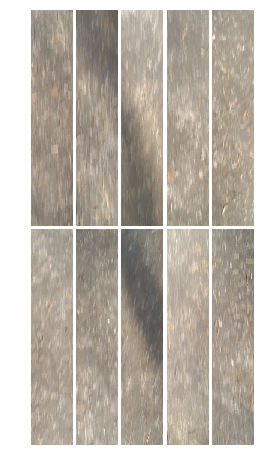

In [105]:
# Einige Beispiele von unbefestigten Wegen
fig = plt.figure(1,figsize=(8,8))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 5), axes_pad=0.05)
imageToShow = 10
for i, img in enumerate(images[0: imageToShow]):
    ax = grid[i]
    ax.imshow(img)
    ax.axis('off')
plt.show()

In [106]:
# Läd alle Bildaufnahmen der Klasse befestigt
startIndexUnpaved = len(images)
imagePathName = 'C:/Users/morro/Documents/fahrradwegeKlassifizierung/daten/datensatz/22/befestigt/zugeschnitten/'
files = os.listdir(imagePathName)
for file in files:
    if "jpg" not in file:
        continue
    images.append(cv2.cvtColor(cv2.imread(imagePathName + file),cv2.COLOR_BGR2RGB))

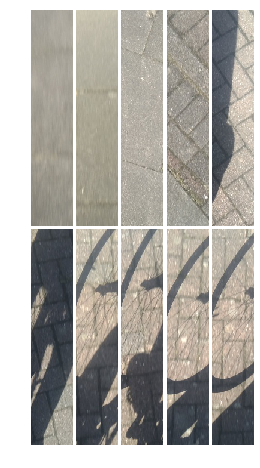

In [107]:
# Einige Beispiele von befestigten Wegen
fig = plt.figure(1,figsize=(8,8))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 5), axes_pad=0.05)
imageToShow = 10
for i, img in enumerate(images[startIndexUnpaved: startIndexUnpaved + imageToShow]):
    ax = grid[i]
    ax.imshow(img)
    ax.axis('off')
plt.show()

In [108]:
# Y Klassen Labels zuweisen
# 0 unbefestigt
# 1 befestigt
yLabels = np.zeros(len(images)) 
yLabels[startIndexUnpaved-1:len(images)] = 1

In [109]:
# Erstellt einen "one hot encoding vector" für die gelabelten Bilder
yLabels = np_utils.to_categorical(yLabels, 0)

In [110]:
# Setzten des RandomState um reproduzierbare Ergebnisse zu erzielen.
np.random.seed(42)

In [111]:
imagesNp = np.array(images)
imagesNp = imagesNp.astype('float32')
# Transfomierung der Bildpunkte auf den Wetebereich von 0 bis 1
imagesNp /= 255
print (imagesNp.shape) # Form des Arrays (Anzahl der Bilder, Höhe, Breite, Farbkanäle)

(2000, 362, 70, 3)


In [112]:
# Mischen der Trainingsdaten
xShuffle, yShuffle = shuffle(imagesNp,yLabels)
# Aufteilung in Trainings und Testdaten
xTrain, xTest, yTrain, yTest = train_test_split(xShuffle, yShuffle, test_size=0.2)

In [113]:
len(xTrain) # Anzahl der Trainingsdaten

1600

In [114]:
len(yTest) # Anzahl der Testdaten

400

<b> Initialisierung des Faltungsnetz </b>
*****

In [115]:
# Parameter für das CNN
inputShape     = imagesNp[0].shape # Eingangs Array-Form 
numNeuronsC1   = 32                # Anzahl der Filter / 1 Faltungsschicht
numNeuronsC2   = 32                # Anzahl der Filter / 2 Faltungsschicht
numNeuronsC3   = 64                # Anzahl der Filter / 3 Faltungsschicht
numNeuronsD1   = 64                # Anzahl der Neuronen des Fully connected layer - vollverbundene Schicht
poolSize       = 2                 # Größe der Pooling-Layer
convKernelSize = 3                 # Größe des Faltungskern n*n

In [116]:
model = Sequential()
model.add(Conv2D(numNeuronsC1, (convKernelSize, convKernelSize), padding='valid',input_shape=inputShape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(poolSize, poolSize)))
model.add(Dropout(0.4))

model.add(Conv2D(numNeuronsC2, (convKernelSize, convKernelSize)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(poolSize, poolSize)))
model.add(Dropout(0.09))
  
model.add(Conv2D(numNeuronsC3, (convKernelSize, convKernelSize)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(poolSize, poolSize)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(numNeuronsD1))
model.add(Activation('relu'))
model.add(Dropout(0.56))

model.add(Dense(2))
model.add(Activation('softmax')) 

In [117]:
# Zusammenfassung der Parameter des neuralen Netzes
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 360, 68, 32)       896       
_________________________________________________________________
activation_64 (Activation)   (None, 360, 68, 32)       0         
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 180, 34, 32)       0         
_________________________________________________________________
dropout_51 (Dropout)         (None, 180, 34, 32)       0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 178, 32, 32)       9248      
_________________________________________________________________
activation_65 (Activation)   (None, 178, 32, 32)       0         
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 89, 16, 32)        0         
__________

<b> Trainieren des Faltungsnetz</b>
*****

In [118]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=["accuracy"])

In [119]:
numEpoch=10
hist = model.fit(xTrain, yTrain, batch_size=16, epochs=numEpoch, verbose=1, validation_data=(xTest, yTest))

Train on 1600 samples, validate on 400 samples
Epoch 1/10
1600/1600 [==============================] - 4s 3ms/step - loss: 0.7434 - acc: 0.5444 - val_loss: 0.6952 - val_acc: 0.5200
Epoch 2/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.6519 - acc: 0.6338 - val_loss: 0.7384 - val_acc: 0.5200
Epoch 3/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.5628 - acc: 0.7212 - val_loss: 0.5727 - val_acc: 0.5200
Epoch 4/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.5331 - acc: 0.7606 - val_loss: 0.4763 - val_acc: 0.8375
Epoch 5/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.5035 - acc: 0.7837 - val_loss: 0.7685 - val_acc: 0.5200
Epoch 6/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.4764 - acc: 0.8006 - val_loss: 0.4504 - val_acc: 0.8175
Epoch 7/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.4581 - acc: 0.8194 - val_loss: 0.4327 - val_acc: 0.8275
Epoch 8/10
1600

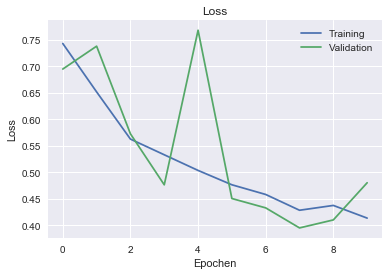

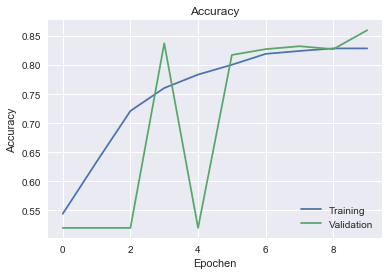

In [120]:
plt.figure(4)
plt.title('Loss')
plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.grid(True)
plt.figure(1)
plt.title('Accuracy')
plt.xlabel('Epochen')
plt.ylabel('Accuracy')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['Training', 'Validation'], loc='lower right')
plt.grid(True)
plt.show()

In [121]:
# Test Score
score = model.evaluate(xTest, yTest, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

Test Loss: 0.4801828682422638
Test accuracy: 0.86


[[199   9]
 [ 47 145]]


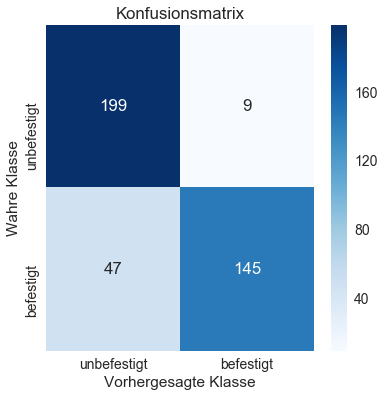

In [122]:
# Konfusionsmatrix
valid_preds = model.predict(xTest)
valid_preds = np.argmax(valid_preds, axis=1)
y_test_max = np.argmax(yTest,axis=1)
cnf_matrix = confusion_matrix(y_test_max, valid_preds)
print(cnf_matrix)
seaborn.set(font_scale=1.4)
fig, ax = plt.subplots(figsize=(6,6)) 
ax = seaborn.heatmap(cnf_matrix, fmt="d", cmap=plt.cm.Blues, ax=ax , annot=True)
ax.set_xticklabels(classNames)
ax.set_yticklabels(classNames)
plt.title('Konfusionsmatrix')
plt.ylabel('Wahre Klasse')
plt.xlabel('Vorhergesagte Klasse')
plt.show()

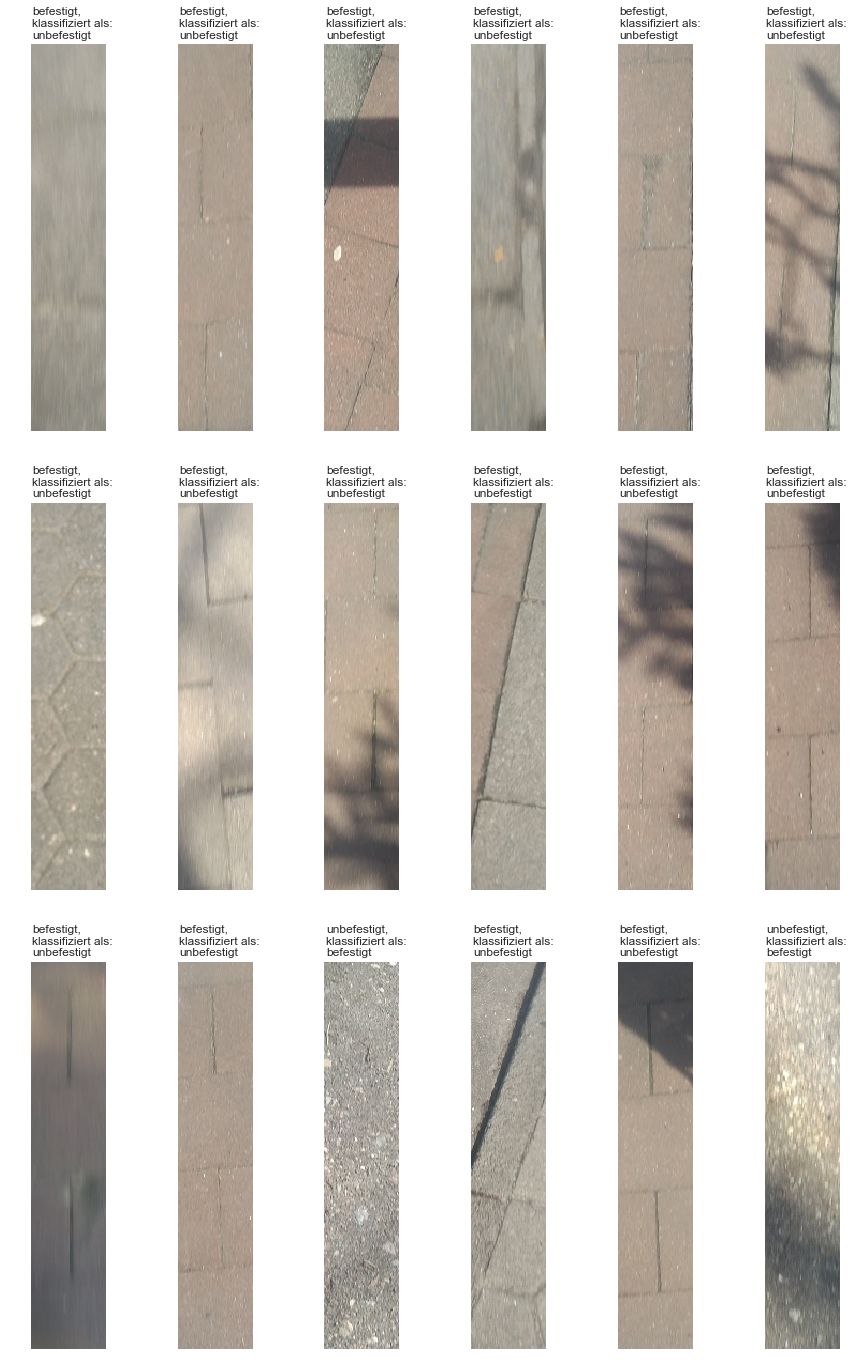

In [123]:
# Plot falsch vorhergesagte Bilder
predicted_classes = model.predict_classes(xTest)   
y_test_number = np.argmax(yTest, axis=1)
incorrect = []
for i, y in enumerate(y_test_number):
    if y != predicted_classes[i]:
        incorrect.append(i)
seaborn.set(font_scale=1)
fig = plt.figure(1, figsize=(24,24))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 6), axes_pad=1.0)
for i, incorr in enumerate(incorrect[0:18]):
    ax = grid[i]
    ax.imshow(xTest[incorr], cmap='gray')
    ax.text(1,-20, classNames[y_test_number[incorr]] + ",\nklassifiziert als: \n" + classNames[predicted_classes[incorr]], verticalalignment='center')
    ax.axis('off')
plt.show()     

<b> Hyperparameter Tuning mit Hyperas  </b>
*****

In [128]:
# Eine Funktion die das zu optimierende Keras-Modell beschreibt
# Die vorgehensweise mit einer Funktion ist nach der Dokumentation von Hyperas vorgegeben 
# siehe https://github.com/maxpumperla/hyperas
def model(xTrain, xTest, yTrain, yTest):
    # Parameter für das CNN
    inputShape     = xTrain[0].shape   # Eingangs Array-Form 
    numNeuronsC1   = 32                # Anzahl der Filter / 1 Faltungsschicht
    numNeuronsC2   = 32                # Anzahl der Filter / 2 Faltungsschicht
    numNeuronsC3   = 64                # Anzahl der Filter / 3 Faltungsschicht
    numNeuronsD1   = 64                # Anzahl der Neuronen des Fully connected layer - vollverbundene Schicht
    poolSize       = 2                 # Größe der Pooling-Layer
    convKernelSize = 3                 # Größe des Faltungskern n*n
    
    model = Sequential()
    model.add(Conv2D(numNeuronsC1, (convKernelSize, convKernelSize), padding='valid',input_shape=inputShape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(poolSize, poolSize)))
    model.add(Dropout({{uniform(0, 1)}}))

    model.add(Conv2D(numNeuronsC2, (convKernelSize, convKernelSize)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(poolSize, poolSize)))
    model.add(Dropout({{uniform(0, 1)}}))
    
    model.add(Conv2D(numNeuronsC3, (convKernelSize, convKernelSize)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(poolSize, poolSize)))
    model.add(Dropout({{uniform(0, 1)}}))

    model.add(Flatten())
    model.add(Dense(numNeuronsD1))
    model.add(Activation('relu'))
    model.add(Dropout({{uniform(0, 1)}}))

    model.add(Dense(2))
    model.add(Activation('softmax'))
    
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=["accuracy"])
    print('Train...')
    model.fit(xTrain, yTrain, batch_size=32, epochs=10,
              validation_data=(xTest, yTest))
    score, acc = model.evaluate(xTest, yTest, batch_size=32)

    print('Test score:', score)
    print('Test accuracy:', acc)
    # DIe Rückgabewerte werden verarbeitet von Hyperas
    # loss ist die Kostenfunktion welche minimiert werden soll mit Hyperas
    # status (STATUS_OK) gibt an das, dass Modell erfolgreich ausgeführt wurde
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}

In [129]:
def data():
    images = []
    # Läd alle Bildaufnahmen der Klasse unbefestigt 
    imagePathName = 'C:/Users/morro/Documents/fahrradwegeKlassifizierung/daten/datensatz/22/unbefestigt/zugeschnitten/'
    files = os.listdir(imagePathName)
    for file in files:
        if "jpg" not in file:
            continue
        images.append(cv2.cvtColor(cv2.imread(imagePathName + file),cv2.COLOR_BGR2RGB))
    # Läd alle Bildaufnahmen der Klasse befestigt
    startIndexUnpaved = len(images)
    imagePathName = 'C:/Users/morro/Documents/fahrradwegeKlassifizierung/daten/datensatz/22/befestigt/zugeschnitten/'
    files = os.listdir(imagePathName)
    for file in files:
        if "jpg" not in file:
            continue
        images.append(cv2.cvtColor(cv2.imread(imagePathName + file),cv2.COLOR_BGR2RGB))
    # Y Klassen Labels zuweisen
    yLabels = np.zeros(len(images)) 
    yLabels[startIndexUnpaved-1:len(images)] = 1
    # Erstellt einen "one hot encoding vector" für die gelabelten Bilder
    yLabels = np_utils.to_categorical(yLabels, 0)
    # Setzten des RandomState um reproduzierbare Ergebnisse zu erzielen.
    np.random.seed(42)
    imagesNp = np.array(images)
    imagesNp = imagesNp.astype('float32')
    # Transfomierung der Bildpunkte auf den Wetebereich von 0 bis 1
    imagesNp /= 255
    
    xShuffle, yShuffle = shuffle(imagesNp,yLabels)
    # Aufteilung in Trainings und Testdaten
    xTrain, xTest, yTrain, yTest = train_test_split(xShuffle, yShuffle, test_size=0.2)
    print('data functioN')
    return xTrain, xTest, yTrain, yTest

In [130]:
# Die Hyperas Methode optim sucht im Suchraum die Parameter 
best_run, best_model = optim.minimize(model=model,               
                                          data=data,
                                          algo=rnd.suggest,   # Algorithmus: Random Search
                                          max_evals=10,          
                                          trials=Trials(),      # eine Liste von Verzeichnissen, die alles über die Suche enthalten.
                                          notebook_name='CNN_experiment1')  # Der Name des Notebooks sollte als String angegeben werden
print(best_run)

>>> Imports:
#coding=utf-8

from __future__ import print_function

try:
    from hyperopt import Trials, STATUS_OK, rand
except:
    pass

try:
    from hyperas import optim
except:
    pass

try:
    from hyperas.distributions import uniform, choice
except:
    pass

try:
    import os
except:
    pass

try:
    import cv2
except:
    pass

try:
    from keras.utils import np_utils
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers.core import Dense, Dropout, Activation, Flatten
except:
    pass

try:
    from keras.layers.convolutional import Conv2D, MaxPooling2D
except:
    pass

try:
    from keras.optimizers import RMSprop
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import pandas
except:
    pass

try:
    from sklearn.utils import shuffle
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from sklearn.metrics import confusion_matrix
except:

1600/1600 [==============================] - 3s 2ms/step - loss: 0.6293 - acc: 0.6825 - val_loss: 0.7293 - val_acc: 0.4800
Epoch 10/10
400/400 [==============================] - 0s 581us/step
Test score: 0.734626076221466
Test accuracy: 0.48
Train...
Train on 1600 samples, validate on 400 samples
Epoch 1/10
1600/1600 [==============================] - 4s 2ms/step - loss: 3.2599 - acc: 0.5150 - val_loss: 0.6924 - val_acc: 0.5200
Epoch 2/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.6975 - acc: 0.5575 - val_loss: 0.6924 - val_acc: 0.5200
Epoch 3/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.6214 - acc: 0.6519 - val_loss: 0.6948 - val_acc: 0.5200
Epoch 4/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.6132 - acc: 0.6575 - val_loss: 0.6971 - val_acc: 0.5200
Epoch 5/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.5735 - acc: 0.7081 - val_loss: 0.7020 - val_acc: 0.5200
Epoch 6/10
1600/1600 [==========

Epoch 3/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.6394 - acc: 0.6669 - val_loss: 0.6667 - val_acc: 0.5200
Epoch 4/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.5585 - acc: 0.7500 - val_loss: 0.9240 - val_acc: 0.5200
Epoch 5/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.5078 - acc: 0.7731 - val_loss: 0.6184 - val_acc: 0.5375
Epoch 6/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.5008 - acc: 0.7894 - val_loss: 1.4001 - val_acc: 0.5200
Epoch 7/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.5003 - acc: 0.7950 - val_loss: 0.6964 - val_acc: 0.5200
Epoch 8/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.4317 - acc: 0.8200 - val_loss: 0.9353 - val_acc: 0.5500
Epoch 9/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.4317 - acc: 0.8263 - val_loss: 1.1515 - val_acc: 0.5500
Epoch 10/10
400/400 [==============================] - 0s 582u

In [133]:
# Hyperas Ergebnisse des gefundenen Modells
best_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_53 (Conv2D)           (None, 360, 68, 32)       896       
_________________________________________________________________
activation_89 (Activation)   (None, 360, 68, 32)       0         
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 180, 34, 32)       0         
_________________________________________________________________
dropout_71 (Dropout)         (None, 180, 34, 32)       0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 178, 32, 32)       9248      
_________________________________________________________________
activation_90 (Activation)   (None, 178, 32, 32)       0         
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 89, 16, 32)        0         
__________

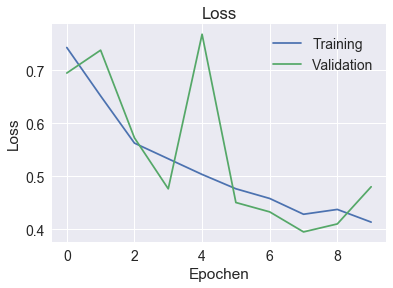

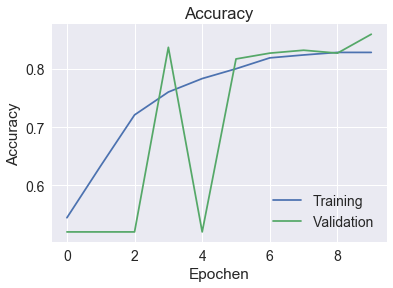

In [148]:
plt.figure(4)
plt.title('Loss')
plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.grid(True)
plt.figure(1)
plt.title('Accuracy')
plt.xlabel('Epochen')
plt.ylabel('Accuracy')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['Training', 'Validation'], loc='lower right')
plt.grid(True)
plt.show()

[[205   3]
 [116  76]]


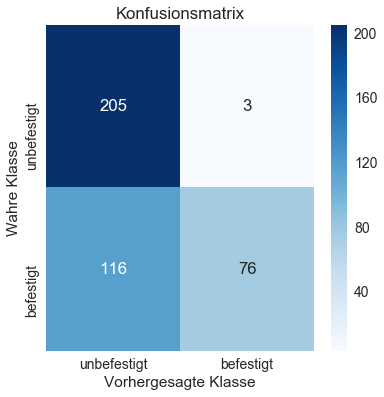

In [136]:
# Konfusionsmatrix
valid_preds = best_model.predict(xTest)
valid_preds = np.argmax(valid_preds, axis=1)
y_test_max = np.argmax(yTest,axis=1)
cnf_matrix = confusion_matrix(y_test_max, valid_preds)
print(cnf_matrix)
seaborn.set(font_scale=1.4)
fig, ax = plt.subplots(figsize=(6,6)) 
ax = seaborn.heatmap(cnf_matrix, fmt="d", cmap=plt.cm.Blues, ax=ax , annot=True)
ax.set_xticklabels(classNames)
ax.set_yticklabels(classNames)
plt.title('Konfusionsmatrix')
plt.ylabel('Wahre Klasse')
plt.xlabel('Vorhergesagte Klasse')
plt.show()

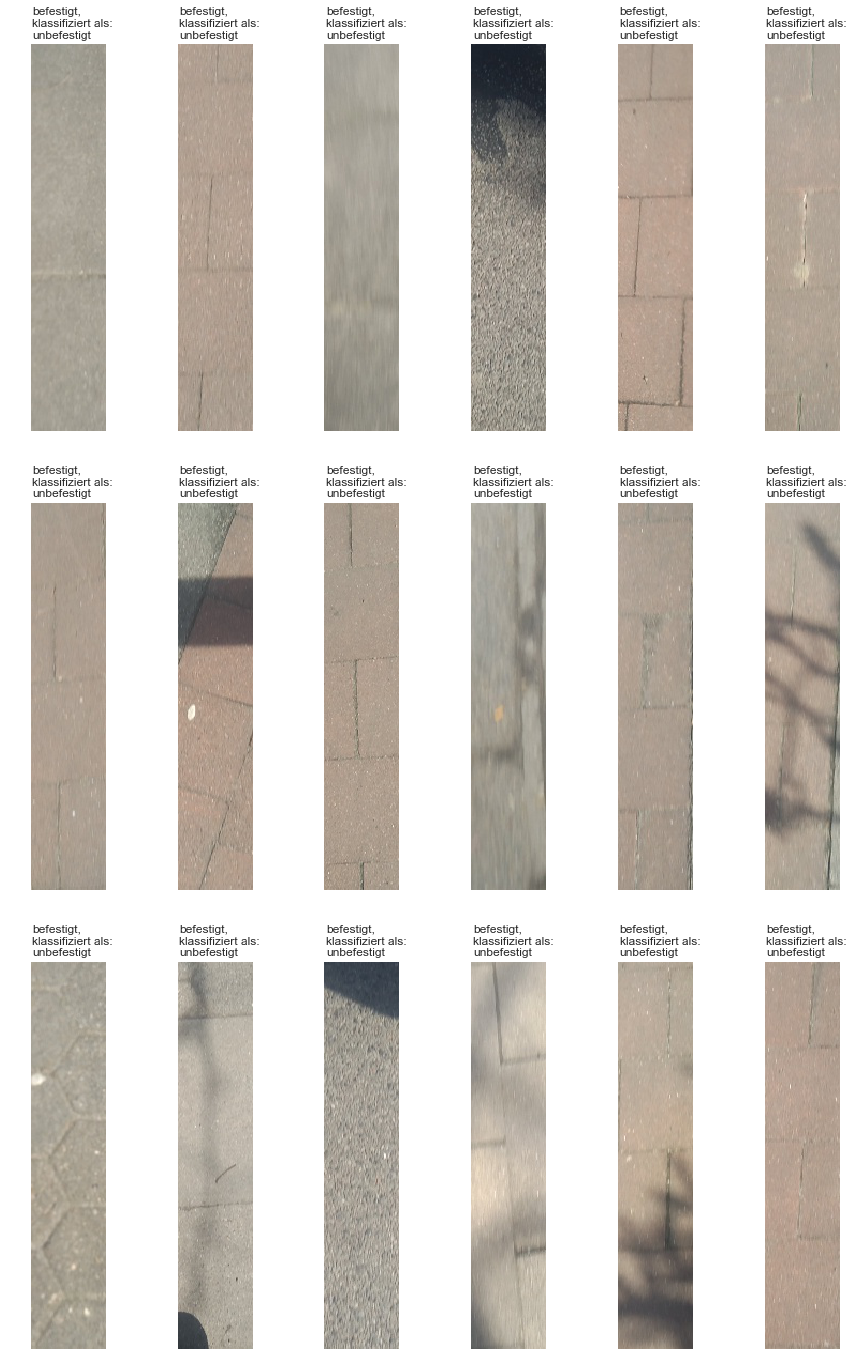

In [134]:
# Plot falsch vorhergesagte Bilder
predicted_classes = best_model.predict_classes(xTest)   
y_test_number = np.argmax(yTest, axis=1)
incorrect = []
for i, y in enumerate(y_test_number):
    if y != predicted_classes[i]:
        incorrect.append(i)
seaborn.set(font_scale=1)
fig = plt.figure(1, figsize=(24,24))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 6), axes_pad=1.0)
for i, incorr in enumerate(incorrect[0:18]):
    ax = grid[i]
    ax.imshow(xTest[incorr], cmap='gray')
    ax.text(1,-20, classNames[y_test_number[incorr]] + ",\nklassifiziert als: \n" + classNames[predicted_classes[incorr]], verticalalignment='center')
    ax.axis('off')
plt.show() 

In [147]:
# Speichert Modell mit der Architektur und Gewichten ab (siehe https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model)
best_model.save('ergebnisse_versuch1/teilversuch1')